<a href="https://colab.research.google.com/github/abi672003/-Using-a-pre-trained-model-Besides-ResNet-on-Animal-Images-Dataset/blob/main/Mini_Project_45.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Pre-trained model**

In [ ]:
# imports

import numpy as np
import pandas as pd
from pathlib import Path

from collections import Counter

from sklearn.model_selection import train_test_split

from PIL import Image


import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.transforms import (Compose,
                                    RandomResizedCrop,
                                    Resize,
                                    CenterCrop,
                                    RandomHorizontalFlip,
                                    RandomVerticalFlip,
                                    RandomPerspective,
                                    RandomRotation,
                                    ColorJitter,
                                    Normalize,
                                    ToTensor
                                   )


from tqdm.notebook import tqdm

import gc

In [ ]:
!pip install torchmetrics
import torchmetrics

In [ ]:
paths = []
labels = []
import os

ds_path = '/content/drive/MyDrive/animals'
for category in ['cats','dogs','panda']:
    for p in os.listdir(os.path.join(ds_path, category)):
        f = Path(os.path.join(ds_path,category, p))
        paths.append(f)
        labels.append(f.parent.stem)

In [ ]:
Counter(labels)

Counter({'cats': 1000, 'dogs': 1000, 'panda': 1000})

In [ ]:
# variation in image sizes

sizes = []
for path in paths:
    im = Image.open(path)
    sizes.append(im.size)
    im.close()

print(max(sizes), min(sizes))
del sizes

(1600, 1200) (55, 75)


In [ ]:
x_train, x_test, y_train, y_test = train_test_split(paths, labels, test_size=0.2, random_state=1357)

In [ ]:
basic_augmentations = Compose([
    Resize(224),
    CenterCrop(224),
    ToTensor()
])

basic_augmentations2 = Compose([
    RandomResizedCrop(224),
    ToTensor()
])
train_augmentations = Compose([
    RandomResizedCrop(224),
    RandomHorizontalFlip(1),
    RandomVerticalFlip(0.1),
    RandomPerspective(distortion_scale=0.2, p=0.2),
    RandomRotation(15),
    ToTensor(),
    Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])
val_augmentations = Compose([
    Resize(384),
    CenterCrop(224),
    ToTensor(),
    Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])
class AnimalDataset:

    def __init__(self, paths, labels, augmentations):
        self.paths = paths
        self.labels = labels
        self.classes = {
            'panda': 0,
            'dog': 1,
            'cat': 2
        }
        self.augmentations = augmentations

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):

        sample = Image.open(self.paths[idx]).convert(mode="RGB")
        sample = self.augmentations(sample)

        label = self.labels[idx]
        if label == 'panda':
            label = 0
        elif label == 'dogs':
            label = 1
        elif label == 'cats':
            label = 2

        return (sample, torch.tensor(label, dtype=torch.long))
train_ds = AnimalDataset(x_train, y_train, train_augmentations)
val_ds = AnimalDataset(x_test, y_test, val_augmentations)

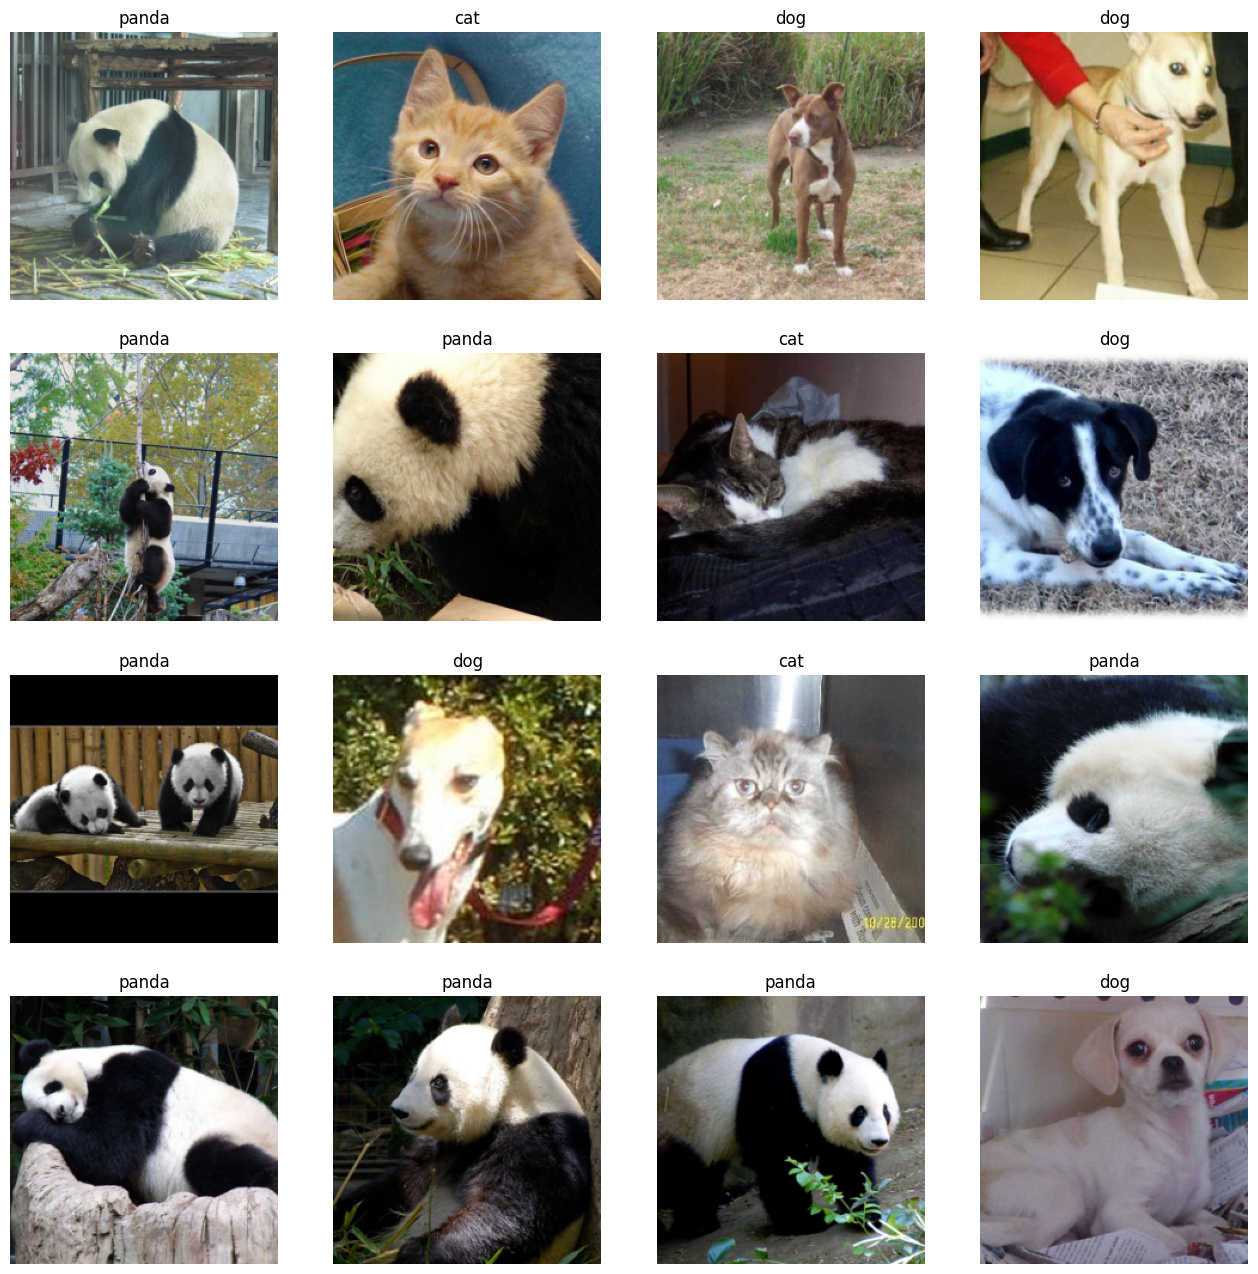

In [ ]:
plot_ds = AnimalDataset(x_train[:16], y_train[:16], basic_augmentations)
to_plot = []
classes = { 0: 'panda',
            1: 'dog',
            2: 'cat'
          }
for x,y in plot_ds:
    to_plot.append((x,y))

import matplotlib.pyplot as plt

figure = plt.figure(figsize=(16,16))
for i in range(1,17):
    img = to_plot[i-1][0].permute(1,2,0)
    label = classes[(to_plot[i-1][1]).item()]
    figure.add_subplot(4,4,i)
    plt.title(label)
    plt.axis('off')
    plt.imshow(img)

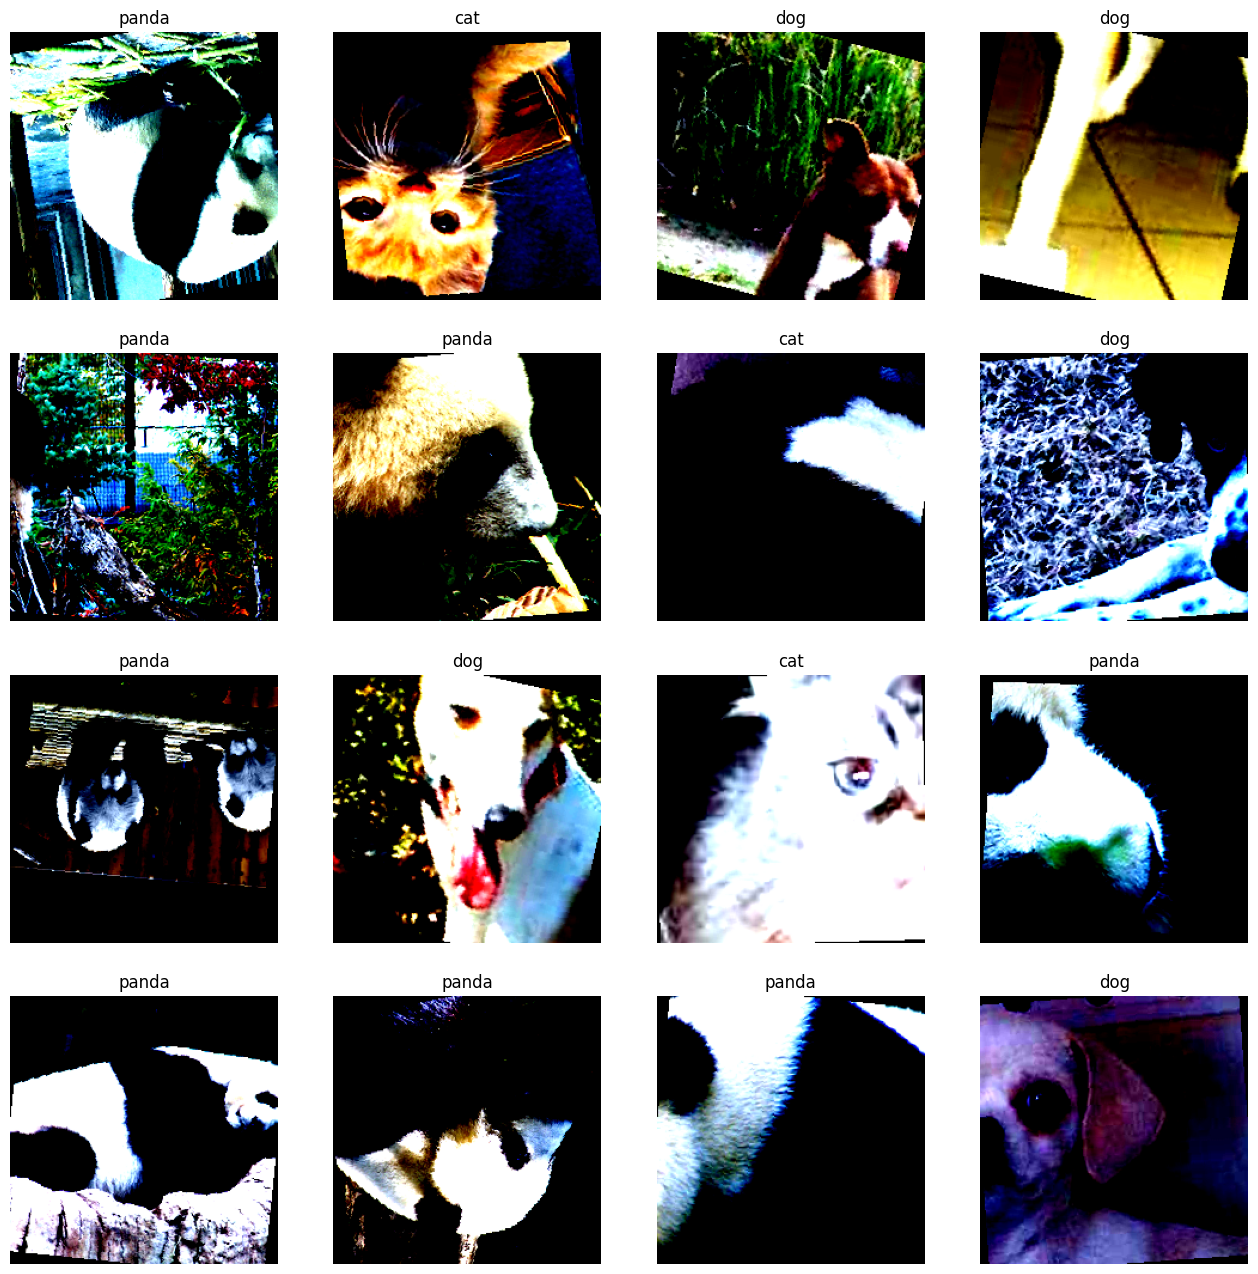

In [ ]:
plot_ds_augmented = [train_ds[i] for i in range(16)]

figure = plt.figure(figsize=(16,16))
for i in range(1,17):
    img = plot_ds_augmented[i-1][0].permute(1,2,0)
    label = classes[(to_plot[i-1][1]).item()]
    figure.add_subplot(4,4,i)
    plt.title(label)
    plt.axis('off')
    plt.imshow(img)

In [ ]:
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=64, num_workers=2, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_ds, batch_size=64, num_workers=2, shuffle=True)
len(train_loader), len(val_loader)

(38, 10)

In [ ]:
class CNNModel(nn.Module):

    def __init__(self, in_features=3, num_classes=3):
        self.in_features = in_features
        self.num_classes = num_classes

        super(CNNModel, self).__init__()

        self.backbone = nn.Sequential(
            nn.Conv2d(self.in_features,32,3),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32,64,3),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2),

            nn.Conv2d(64,128,3),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(128,256,3),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(2),

            nn.Dropout2d(0.5)
        )

        self.head = nn.Sequential(
            nn.Flatten(),
            nn.AdaptiveAvgPool1d(256),
            nn.Linear(256,self.num_classes)
        )

    def forward(self,x):
        x = self.backbone(x)
        x = self.head(x)
        return x
print(CNNModel())

CNNModel(
  (backbone): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
    (11): ReLU()
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Dropout2d(p=0.5, inplace=False)
  )
  (head): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): AdaptiveAvgPool1d(output